# 3. Construct and test variables 

This Notebook is created to merge all relevant DataFrames for each company, and in order to retrieve the relevant daily data. These daily variables are then tested in order to satisfy the constraints the AR-GARCH-X model imposes on the variables.

## 3.1. Load data and packages

### 3.1.1 Load packages

Import all the relevant packages needed for the main analysis

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys
from datetime import datetime
from scipy.stats import pearsonr

# Load data that returns tweets
sys.path.insert(0, os.path.abspath('C:\\Users\\Jonas\\PycharmProjects\\TwitterSentimentGARCH2021\\Code\\Variable construction and tests'))
from variableconstruction import VariableSelection

# Get path with the Time-varying specification function
sys.path.insert(0, os.path.abspath(r'C:\Users\Jonas\PycharmProjects\TwitterSentimentGARCH2021\Code\GARCH model\tvGARCH models'))
from helper_func import regimeshift

### 3.1.2. Colors for plots

Construct color code

In [2]:
colors = ['seagreen', 'mediumaquamarine', 'steelblue', 'cornflowerblue', 'navy', 'black']

### 3.1.3 Load data

Give the location of all Data objects, as some of the data is company specific, also load the company names.

In [3]:
# Load company name data
data_loc = r'C:\Users\Jonas\Documents\Data'
file_name_comp = '\company_ticker_list_all.xlsx'

df_comp_names = pd.read_excel(data_loc + file_name_comp)

# Specify return data location
return_loc = r'C:\Users\Jonas\Documents\Data\Returns'

# Specify sentiment data location
sentiment_loc = r'C:\Users\Jonas\Documents\Data\Sentiment'

# Load control variable data
store_loc = r'C:\Users\Jonas\Documents\Data\Control variables'
file_VIX = '\\VIX.csv'
file_ted = '\\TEDRATE.csv'
df_vix = pd.read_csv(store_loc+file_VIX).set_index('Date')
df_ted = pd.read_csv(store_loc+file_ted).set_index('DATE')

df_control = pd.merge(df_vix, df_ted, left_index=True, right_index=True, how='inner')

# Convert values in TEDRATE column to floats, remove '.' and then interpolate
df_control.TEDRATE = df_control.TEDRATE.replace('.', None)
df_control.TEDRATE = df_control.TEDRATE.astype(float)
df_control.TEDRATE = df_control.TEDRATE.interpolate()

# Reset index
df_control = df_control.reset_index()

# Rename Close to VIX
df_control = df_control.rename(columns={'Close':'VIX'})

### 3.1.4 Determine relevant columns

Use first entry to inspect the columns of the sentiment and return data.

In [4]:
# Load first entry of return data and print column names
df_returns = pd.read_csv(return_loc + f'//{df_comp_names.Symbol.iloc[0]}.csv')
print(df_returns.columns)

# Load first entry of sentimnent data and print column names
df_sentiment = pd.read_csv(sentiment_loc + f'//sentiment {df_comp_names.Company.iloc[0]}.csv')
print(df_sentiment.columns)

# Also inspect control DataFrame columns
print(df_control.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Unnamed: 0', 'date', 'close/open', 'sentiment', 'n_interactions',
       'n_tweets'],
      dtype='object')
Index(['index', 'Open', 'High', 'Low', 'VIX', 'Adj Close', 'Volume',
       'TEDRATE'],
      dtype='object')


In [8]:
RG = (1/ (2 * np.sqrt(2))) * (df_returns.High - df_returns.Low)

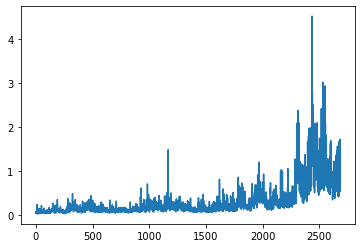

In [9]:
plt.plot(RG)

From the print statement, keep columns that might hold valuable information

In [6]:
# Set columns that we want to keep: returns
returns_cols = ['returns', 'Volume']
return_date_col = 'Date'

# Set columns that we want to keep: sentiment
sentiment_cols = ['sentiment', 'n_interactions', 'n_tweets']
sentiment_date_col = 'date'

# Set columns that we want to keep: control variables
control_cols = ['VIX', 'TEDRATE']
control_date_col = 'index'

### 3.1.5 Determine store location

Determine location where DataFrames can be stored

In [7]:
store_loc = r'C:\Users\Jonas\Documents\Data\Total_data'

-----
-----

## 3.2. Inspect data

In this section, inspect the data before it is tested, and make some plots

First, make plot of the control variables

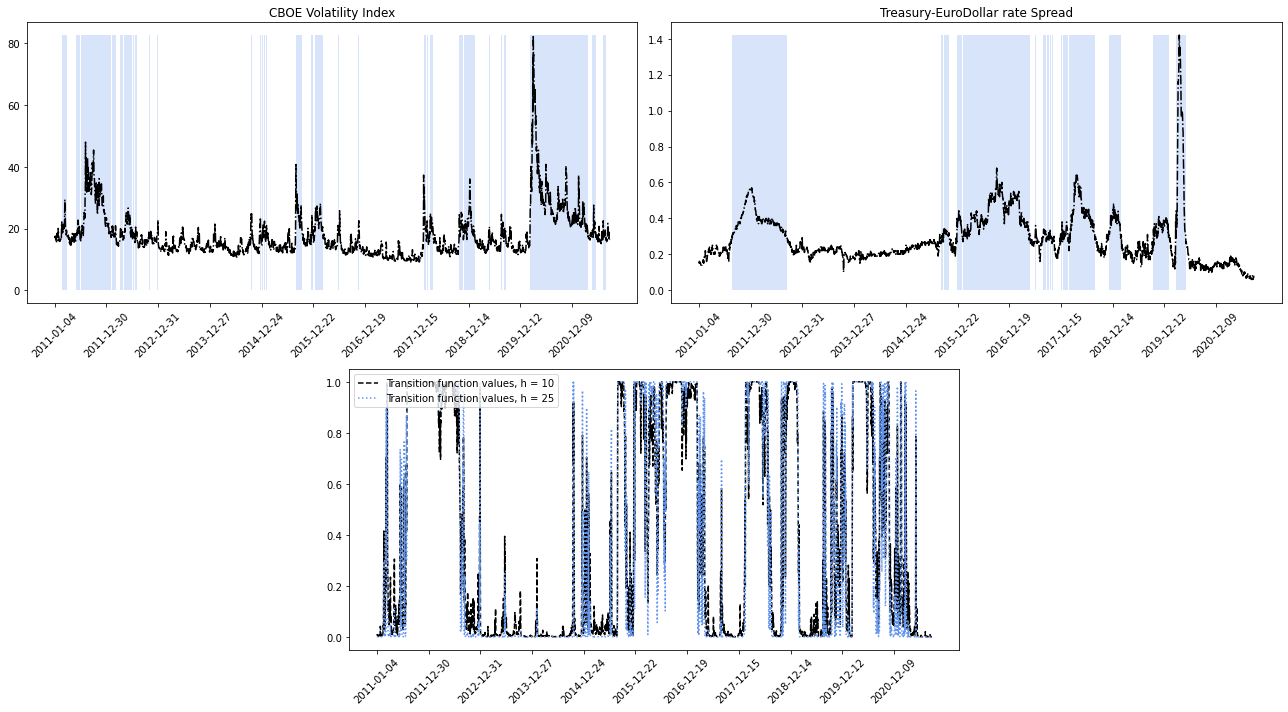

In [7]:
# Get possible values of h
h_vals = [10, 25]
styles = ['--', ':']
colors = ['black', 'cornflowerblue']

# Create DataFrame indicating the regime, using the regimeshift function
df_regime = pd.DataFrame()
df_regime['date'] = df_control['index'].values
for col in control_cols:
    df_regime[col] = (df_control[col] - df_control[col].mean()) / df_control[col].std()

for h in h_vals:
    df_regime[f'{h}'] = regimeshift(df_regime, control_cols, h, [0, 0])

# Plot control variables & regime
fig = plt.figure(figsize=(18,10), tight_layout=True)
spec = gridspec.GridSpec(ncols=8, nrows=2, figure=fig)

# Get subplots
ax1 = fig.add_subplot(spec[0,0:4])
ax2 = fig.add_subplot(spec[0,4:8])
ax3 = fig.add_subplot(spec[1,2:6])
axs = [ax1, ax2, ax3]
    
first_date, last_date = df_control['index'][0], df_control['index'][len(df_control)-1]
n = 250  # keeps every 250th label (around 1 year)

for j in range(len(axs)):
    # plot something differenct on both axes
    if j == 0:
        axs[j].plot(df_control['index'], df_control.VIX, c='black', linestyle='-.')
        axs[j].fill_between(df_control['index'], 0, max(df_control.VIX), where= df_control.VIX > np.mean(df_control.VIX), facecolor='cornflowerblue', alpha=0.25)
        axs[j].set_title(f'CBOE Volatility Index')
    elif j == 1:
        axs[j].plot(df_control['index'], df_control.TEDRATE, c='black', linestyle='-.')
        axs[j].fill_between(df_control['index'], 0, max(df_control.TEDRATE), where= df_control.TEDRATE > np.mean(df_control.TEDRATE), facecolor='cornflowerblue', alpha=0.25)
        axs[j].set_title(f'Treasury-EuroDollar rate Spread')
    else:
        for h, ls, color in zip(h_vals, styles, colors):
            axs[j].plot(df_regime['date'], df_regime[f'{h}'], linestyle=ls, color=color, label = f'Transition function values, h = {h}')
            axs[j].legend(loc='upper left')
            
    # Set title and xticklabels
    axs[j].set_xticks(axs[j].get_xticks()[::n])
        
    axs[j].tick_params(axis='x', labelrotation = 45)
    
plt.tight_layout()
    
# Store figures as PNG
fig.savefig(os.path.join(store_loc, f'control_variables.png'))
    

## 3.3. Perform analysis

### 3.3.1. Calculate total df's and store them

This section exploits the class `VariableSelection` to merge all DataFrames and perform tests to check if the variables satisfy all constraints needed to serve as input for a GARCH model. This code checks out whether the variables do not have a unit-root with help of the Dickey-Fuller test. If a unit root is present, the percentual difference of a variable is then tested for a unit-root, if this variable does not have a unit root, the percentual difference will be taken instead of the variable itself, the percentual difference is in turn standardized as well.

In [8]:
for i in range(len(df_comp_names)):    
    company_name = df_comp_names.iloc[i]['Company']
    ticker = df_comp_names.iloc[i]['Symbol']
    
    # Get df_returns
    returns_name = f'//{ticker}.csv'
    df_returns = pd.read_csv(return_loc + returns_name)   
    df_returns['returns'] = 100 * np.log(df_returns.Close).diff() # Calculate returns in percentages
    df_returns = df_returns.dropna()

    # Get df_sentiment
    sentiment_name = f'//sentiment {company_name}.csv'   
    df_sentiment = pd.read_csv(sentiment_loc + sentiment_name)
    
    # Shrink df's to contain only columns that are of interest
    df_returns = df_returns[[return_date_col] + returns_cols]
    df_sentiment = df_sentiment[[sentiment_date_col] + sentiment_cols]
    df_control = df_control[[control_date_col] + control_cols]
    
    # Use VariableSelection to find total DataFrame
    select_object = VariableSelection(df_returns=df_returns, 
                                      df_sentiment=df_sentiment, 
                                      df_control=df_control, 
                                      date_col_ret=return_date_col, 
                                      date_col_sent=sentiment_date_col, 
                                      date_col_control=control_date_col, 
                                      return_cols=returns_cols, 
                                      sentiment_cols=sentiment_cols, 
                                      control_cols=control_cols)
    
    df_total = select_object.test_stationarity()
    
    # Delete too old data
    if len(df_total) > 2685:
        date = '2011-01-03'
        indice = df_total[df_total.date == date].index.tolist()[0]
        df_total = df_total[indice:]
    
    # Store df_total as an .csv file
    store_name = f'\\total data {company_name}.csv'    
    df_total.to_csv(store_loc + store_name)

(-19.479404761583137, 0.0, 4, 2678, {'1%': -3.432794204326531, '5%': -2.862619868040959, '10%': -2.567344850230434}, 7403.089782365257)
(-5.780803818360345, 5.131362413242045e-07, 28, 2654, {'1%': -3.432816328587004, '5%': -2.8626296386632655, '10%': -2.56735005214861}, 7445.804345582483)
(-4.454289490528709, 0.00023761905466360776, 28, 2654, {'1%': -3.432816328587004, '5%': -2.8626296386632655, '10%': -2.56735005214861}, 6850.032833884753)
(-17.871294266881844, 3.0269009501581978e-30, 5, 2678, {'1%': -3.432794204326531, '5%': -2.862619868040959, '10%': -2.567344850230434}, 7421.914172551072)
(-6.716802377926968, 3.565011396309836e-09, 17, 2666, {'1%': -3.432805216616629, '5%': -2.8626247313505173, '10%': -2.5673474394742724}, 7284.984420441418)
(-4.195334100140198, 0.0006709861219254355, 28, 2655, {'1%': -3.4328153987492263, '5%': -2.8626292280252916, '10%': -2.567349833523076}, 6600.438870970182)
(-17.012341215534107, 8.573371024540473e-30, 5, 2677, {'1%': -3.4327951182428817, '5%': 

### 3.3.2 Construct correlation matrices

To get more insights into how the variables are related, construct and print correlation matrices.

In [9]:
#p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
#rho.round(2).astype(str) + p

for company in df_comp_names['Company']:  
    # Get df_total
    store_name = f'\\total data {company}.csv'  
    df_total = pd.read_csv(store_loc + store_name)
    
    # Drop NA (Can also be done in analysis)
    df_total = df_total.dropna()
    print(f"Correlation matrix of {company}")
    rho = df_total[df_total.columns[df_total.columns != 'date']].corr()
    pval = df_total[df_total.columns[df_total.columns != 'date']].corr(method = lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    rho = rho.round(3).astype(str) + p
    display(rho)
    rho.to_csv(store_loc + f'//correlation of {company}.csv')
    

Correlation matrix of Apple


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.018,-0.688***,0.096***,-0.037*,-0.019,0.229***,-0.282***
returns,0.018,1.0***,-0.077***,-0.108***,0.008,-0.008,-0.05***,-0.003
Volume,-0.688***,-0.077***,1.0***,0.189***,-0.024,-0.042**,-0.115***,0.221***
VIX,0.096***,-0.108***,0.189***,1.0***,0.284***,-0.063***,0.147***,-0.005
TEDRATE,-0.037*,0.008,-0.024,0.284***,1.0***,0.062***,-0.013,0.02
sentiment,-0.019,-0.008,-0.042**,-0.063***,0.062***,1.0***,-0.03,0.01
n_interactions,0.229***,-0.05***,-0.115***,0.147***,-0.013,-0.03,1.0***,0.067***
n_tweets,-0.282***,-0.003,0.221***,-0.005,0.02,0.01,0.067***,1.0***


Correlation matrix of Amazon


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.008,-0.028,0.096***,-0.037*,-0.051***,0.222***,0.469***
returns,0.008,1.0***,-0.018,-0.086***,0.027,0.013,-0.008,-0.01
Volume,-0.028,-0.018,1.0***,0.358***,0.146***,0.04**,0.006,0.045**
VIX,0.096***,-0.086***,0.358***,1.0***,0.284***,-0.037*,0.133***,0.123***
TEDRATE,-0.037*,0.027,0.146***,0.284***,1.0***,0.034*,-0.029,0.016
sentiment,-0.051***,0.013,0.04**,-0.037*,0.034*,1.0***,-0.047**,-0.068***
n_interactions,0.222***,-0.008,0.006,0.133***,-0.029,-0.047**,1.0***,0.288***
n_tweets,0.469***,-0.01,0.045**,0.123***,0.016,-0.068***,0.288***,1.0***


Correlation matrix of Chevron


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,-0.009,0.156***,0.105***,-0.041**,0.079***,0.169***,0.024
returns,-0.009,1.0***,-0.034*,-0.106***,0.032,-0.006,-0.03,-0.001
Volume,0.156***,-0.034*,1.0***,0.622***,0.126***,0.016,0.074***,-0.014
VIX,0.105***,-0.106***,0.622***,1.0***,0.286***,0.017,0.047**,-0.021
TEDRATE,-0.041**,0.032,0.126***,0.286***,1.0***,0.045**,-0.086***,-0.031
sentiment,0.079***,-0.006,0.016,0.017,0.045**,1.0***,-0.036*,-0.134***
n_interactions,0.169***,-0.03,0.074***,0.047**,-0.086***,-0.036*,1.0***,0.053***
n_tweets,0.024,-0.001,-0.014,-0.021,-0.031,-0.134***,0.053***,1.0***


Correlation matrix of Coca-Cola


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,-0.0,-0.108***,0.096***,-0.037*,-0.15***,0.126***,-0.009
returns,-0.0,1.0***,-0.088***,-0.139***,-0.015,0.016,0.013,0.007
Volume,-0.108***,-0.088***,1.0***,0.422***,0.067***,0.05***,0.002,-0.022
VIX,0.096***,-0.139***,0.422***,1.0***,0.284***,-0.001,0.029,-0.043**
TEDRATE,-0.037*,-0.015,0.067***,0.284***,1.0***,0.008,-0.044**,-0.048**
sentiment,-0.15***,0.016,0.05***,-0.001,0.008,1.0***,-0.055***,-0.1***
n_interactions,0.126***,0.013,0.002,0.029,-0.044**,-0.055***,1.0***,0.143***
n_tweets,-0.009,0.007,-0.022,-0.043**,-0.048**,-0.1***,0.143***,1.0***


Correlation matrix of Exxon Mobil


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,-0.036*,0.24***,0.162***,-0.077***,-0.058***,0.071***,0.02
returns,-0.036*,1.0***,-0.035,-0.103***,0.02,0.027,-0.012,-0.017
Volume,0.24***,-0.035,1.0***,0.745***,0.052**,0.0,0.006,-0.043**
VIX,0.162***,-0.103***,0.745***,1.0***,0.244***,-0.017,-0.011,-0.058***
TEDRATE,-0.077***,0.02,0.052**,0.244***,1.0***,-0.021,-0.005,0.039*
sentiment,-0.058***,0.027,0.0,-0.017,-0.021,1.0***,0.006,-0.164***
n_interactions,0.071***,-0.012,0.006,-0.011,-0.005,0.006,1.0***,0.154***
n_tweets,0.02,-0.017,-0.043**,-0.058***,0.039*,-0.164***,0.154***,1.0***


Correlation matrix of McDonalds


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.005,-0.428***,0.096***,-0.037*,0.084***,0.137***,-0.048**
returns,0.005,1.0***,-0.049**,-0.116***,0.012,-0.026,-0.025,-0.031
Volume,-0.428***,-0.049**,1.0***,0.21***,0.113***,-0.027,-0.065***,0.031
VIX,0.096***,-0.116***,0.21***,1.0***,0.284***,-0.014,0.033*,-0.048**
TEDRATE,-0.037*,0.012,0.113***,0.284***,1.0***,0.01,-0.024,-0.028
sentiment,0.084***,-0.026,-0.027,-0.014,0.01,1.0***,-0.021,-0.057***
n_interactions,0.137***,-0.025,-0.065***,0.033*,-0.024,-0.021,1.0***,0.199***
n_tweets,-0.048**,-0.031,0.031,-0.048**,-0.028,-0.057***,0.199***,1.0***


Correlation matrix of Microsoft


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.029,-0.431***,0.096***,-0.037*,0.009,0.387***,0.05***
returns,0.029,1.0***,-0.075***,-0.109***,0.018,-0.002,0.024,-0.023
Volume,-0.431***,-0.075***,1.0***,0.341***,0.052***,-0.045**,-0.116***,0.026
VIX,0.096***,-0.109***,0.341***,1.0***,0.284***,-0.051***,0.107***,0.005
TEDRATE,-0.037*,0.018,0.052***,0.284***,1.0***,0.074***,-0.081***,-0.071***
sentiment,0.009,-0.002,-0.045**,-0.051***,0.074***,1.0***,-0.122***,-0.201***
n_interactions,0.387***,0.024,-0.116***,0.107***,-0.081***,-0.122***,1.0***,0.33***
n_tweets,0.05***,-0.023,0.026,0.005,-0.071***,-0.201***,0.33***,1.0***


Correlation matrix of Netflix


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.007,-0.582***,0.096***,-0.037*,0.18***,0.065***,0.225***
returns,0.007,1.0***,-0.035*,-0.103***,0.01,0.001,0.007,-0.001
Volume,-0.582***,-0.035*,1.0***,0.149***,0.072***,-0.072***,-0.034*,-0.108***
VIX,0.096***,-0.103***,0.149***,1.0***,0.284***,0.09***,0.003,0.028
TEDRATE,-0.037*,0.01,0.072***,0.284***,1.0***,0.025,-0.018,-0.006
sentiment,0.18***,0.001,-0.072***,0.09***,0.025,1.0***,0.011,0.036*
n_interactions,0.065***,0.007,-0.034*,0.003,-0.018,0.011,1.0***,0.056***
n_tweets,0.225***,-0.001,-0.108***,0.028,-0.006,0.036*,0.056***,1.0***


Correlation matrix of NIKE


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.011,-0.238***,0.096***,-0.037*,-0.081***,0.11***,-0.046**
returns,0.011,1.0***,0.014,-0.081***,0.012,-0.019,-0.114***,-0.019
Volume,-0.238***,0.014,1.0***,0.183***,0.163***,-0.006,0.013,-0.011
VIX,0.096***,-0.081***,0.183***,1.0***,0.284***,-0.001,0.149***,-0.08***
TEDRATE,-0.037*,0.012,0.163***,0.284***,1.0***,0.047**,0.028,-0.067***
sentiment,-0.081***,-0.019,-0.006,-0.001,0.047**,1.0***,-0.011,-0.109***
n_interactions,0.11***,-0.114***,0.013,0.149***,0.028,-0.011,1.0***,0.211***
n_tweets,-0.046**,-0.019,-0.011,-0.08***,-0.067***,-0.109***,0.211***,1.0***


Correlation matrix of salesforce


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.009,-0.201***,0.099***,-0.041**,0.392***,0.319***,0.393***
returns,0.009,1.0***,0.013,-0.105***,0.009,-0.002,-0.052***,0.023
Volume,-0.201***,0.013,1.0***,0.299***,0.074***,-0.108***,-0.007,-0.088***
VIX,0.099***,-0.105***,0.299***,1.0***,0.284***,-0.022,0.157***,-0.002
TEDRATE,-0.041**,0.009,0.074***,0.284***,1.0***,0.017,-0.014,-0.057***
sentiment,0.392***,-0.002,-0.108***,-0.022,0.017,1.0***,0.095***,0.218***
n_interactions,0.319***,-0.052***,-0.007,0.157***,-0.014,0.095***,1.0***,0.348***
n_tweets,0.393***,0.023,-0.088***,-0.002,-0.057***,0.218***,0.348***,1.0***


Correlation matrix of Tesla


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.017,0.455***,0.1***,-0.039**,0.094***,0.299***,0.347***
returns,0.017,1.0***,0.075***,-0.078***,-0.005,-0.004,0.005,-0.009
Volume,0.455***,0.075***,1.0***,0.149***,-0.01,0.008,0.132***,0.216***
VIX,0.1***,-0.078***,0.149***,1.0***,0.285***,-0.074***,0.078***,-0.049**
TEDRATE,-0.039**,-0.005,-0.01,0.285***,1.0***,-0.014,-0.096***,0.026
sentiment,0.094***,-0.004,0.008,-0.074***,-0.014,1.0***,-0.014,-0.094***
n_interactions,0.299***,0.005,0.132***,0.078***,-0.096***,-0.014,1.0***,0.305***
n_tweets,0.347***,-0.009,0.216***,-0.049**,0.026,-0.094***,0.305***,1.0***


Correlation matrix of Walmart


,Unnamed: 0,returns,Volume,VIX,TEDRATE,sentiment,n_interactions,n_tweets
Unnamed: 0,1.0***,0.009,-0.108***,0.096***,-0.037*,0.034*,0.152***,-0.033*
returns,0.009,1.0***,-0.09***,-0.045**,0.01,0.002,0.002,-0.001
Volume,-0.108***,-0.09***,1.0***,0.293***,0.121***,-0.004,-0.013,-0.043**
VIX,0.096***,-0.045**,0.293***,1.0***,0.284***,0.047**,0.101***,0.023
TEDRATE,-0.037*,0.01,0.121***,0.284***,1.0***,0.026,0.043**,-0.006
sentiment,0.034*,0.002,-0.004,0.047**,0.026,1.0***,0.021,-0.047**
n_interactions,0.152***,0.002,-0.013,0.101***,0.043**,0.021,1.0***,0.182***
n_tweets,-0.033*,-0.001,-0.043**,0.023,-0.006,-0.047**,0.182***,1.0***


## 3.2.3. Create descriptive statistics

Print out descriptive statistics of the variables included in the model

In [10]:
df_describe = pd.DataFrame()
for company, ticker in zip(df_comp_names['Company'], df_comp_names.Symbol):  
    # Get df_total
    store_name = f'\\total data {company}.csv'  
    df_total = pd.read_csv(store_loc + store_name)
    
    df_total[f'${ticker}'] = df_total['returns']
    
    # Concatenate all company DataFrames
    df_describe = pd.concat([df_describe, df_total[[f'${ticker}', 'VIX', 'TEDRATE']].describe()], axis=1)
    
# Remove duplicate columns  
df_describe = df_describe.loc[:,~df_describe.columns.duplicated()]
display(df_describe)
df_describe.to_csv(store_loc + f'\\descriptive stats.csv')

,$AAPL,VIX,TEDRATE,$AMZN,$CVX,$KO,$XOM,$MCD,$MSFT,$NFLX,$NKE,$CRM,$TSLA,$WMT
count,2683.000000,2.683000e+03,2.683000e+03,2684.000000,2683.000000,2683.000000,2683.000000,2683.000000,2683.000000,2683.000000,2683.000000,2683.000000,2684.000000,2684.000000
mean,0.095310,2.079030e-16,4.599543e-15,0.110253,0.001908,0.020360,-0.011662,0.042169,0.088652,0.115767,0.075858,0.076406,0.183616,0.037638
std,1.786119,1.000000e+00,1.000000e+00,1.961792,1.762077,1.114335,1.572209,1.218814,1.603409,3.148170,1.650103,2.181150,3.466685,1.214349
min,-13.770804,-1.166052e+00,-1.573456e+00,-13.532540,-25.006230,-10.172795,-13.039097,-17.287057,-15.945342,-42.917890,-12.405269,-17.302665,-23.651792,-10.739858
25%,-0.733706,-6.181834e-01,-6.085702e-01,-0.823787,-0.761418,-0.470542,-0.720047,-0.481374,-0.663205,-1.220269,-0.712317,-0.923962,-1.475305,-0.520955
50%,0.085462,-2.711545e-01,-2.639681e-01,0.115211,0.037662,0.030331,-0.013113,0.072875,0.065478,0.032054,0.068296,0.096266,0.117815,0.047123
75%,1.031306,2.589524e-01,5.630771e-01,1.124599,0.777058,0.571924,0.719750,0.585326,0.880297,1.503622,0.894226,1.161349,1.875494,0.608319
max,11.315747,8.882755e+00,7.799722e+00,14.622537,20.490373,6.278296,11.944208,16.657700,13.292898,35.222964,14.437248,23.146799,21.829223,11.072266


-----
-----